In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize.treebank import TreebankWordTokenizer
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate,  Dropout
#from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,classification_report
from sklearn.svm import SVC
import os
import sys

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re, string, unicodedata
from collections import defaultdict

import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer ,PorterStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from textblob import Word

from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_auc_score

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [5]:
def Pre_processing(df):
    """
    This function performs custom normalization on text column
    """
    #Defining the stop words from nltk
    stopwords_all = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    df=df.apply(lambda x: re.sub(r'\([^()]*\)', '', x)) #Remove paranthesis
    df=df.apply(lambda x: x.lower())  #Lowercase the reviews
    df=df.apply(lambda x: re.sub('\w*\d\w*','', x)) #Remove digits and words containing digits
    df=df.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x)) #Remove Punctuations
    df=df.apply(lambda x: re.sub(' +',' ',x))  # remove extra spaces
    df=df.apply(lambda x: re.sub("</?.*?>"," <> ",x))  #remove tags
    df=df.apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split())) # lemmatization
    #df=df.apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # remove single characters like a 
    df=df.apply(lambda x: " ".join([word for word in x.split() if word not in stopwords_all]))
    df=df.apply(lambda x: re.sub(r'([a-z])([A-Z])',r'\1 \2',x))
    
    symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
    symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

    isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
    remove_dict = {ord(c):f'' for c in symbols_to_delete}
    
    df = df.apply(lambda x: x.translate(remove_dict)) 
    df = df.apply(lambda x: x.translate(isolate_dict))
    
    return df

train_df['comment_text'] = Pre_processing(train_df['comment_text'])

In [6]:
# train_final = train_df[:int(len(train_df)*0.85*0.8)]
# validation_final = train_df[int(len(train_df)*0.85*0.8): int(len(train_df)*0.85) ]
# test_final = train_df[int(len(train_df)*0.85) :  ]

# y_train = train_final[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
# y_val = validation_final[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
# y_test =  test_final[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

# target_col = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [7]:
target_col = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

train_df= train_df.append(train_df[train_df.threat==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.threat==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.identity_hate==1], ignore_index=True)
train_df= train_df.append(train_df[train_df.severe_toxic==1], ignore_index=True)

x_tr, X_test, y_tr, y_test = train_test_split(train_df['comment_text'], train_df[target_col], test_size=0.15, random_state=32,stratify=train_df[target_col])
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.193367882, random_state=42,stratify=y_tr)

In [8]:
max_tokens = 53194
maxlen=100

tok = Tokenizer(num_words=max_tokens, oov_token='UNK')
tok.fit_on_texts(x_train)
tok.num_words=max_tokens
x_train_seq = tok.texts_to_sequences(x_train)
x_train_padded = pad_sequences(x_train_seq, maxlen=maxlen)

x_val_seq = tok.texts_to_sequences(x_val)
x_val_padded = pad_sequences(x_val_seq, maxlen=maxlen)

In [9]:
model = Sequential()
model.add(Embedding(max_tokens, 64, input_length=maxlen))
model.add(LSTM(256))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           3404416   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               328704    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 3,741,542
Trainable params: 3,741,542
Non-trainable params: 0
_________________________________________________________________


In [10]:
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
    ModelCheckpoint(filepath='xceptionnet_{epoch:02d}_{val_accuracy:.04f}.h5',
                    save_best_only=False),
]

In [11]:
y_train= np.array(y_train)
y_val= np.array(y_val)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train_padded, y_train,batch_size=256,callbacks=my_callbacks, epochs=10,validation_data=(x_val_padded, y_val))
model.save('/output/LSTM_Glove_19082021.h5')

Epoch 1/10
443/443 [==============================] - 372s 835ms/step - loss: 0.2111 - accuracy: 0.6192 - val_loss: 0.0758 - val_accuracy: 0.9932
Epoch 2/10
443/443 [==============================] - 370s 835ms/step - loss: 0.0727 - accuracy: 0.8991 - val_loss: 0.0710 - val_accuracy: 0.9932
Epoch 3/10
443/443 [==============================] - 367s 829ms/step - loss: 0.0616 - accuracy: 0.9487 - val_loss: 0.0910 - val_accuracy: 0.9932
Epoch 4/10
443/443 [==============================] - 367s 828ms/step - loss: 0.0739 - accuracy: 0.9412 - val_loss: 0.0667 - val_accuracy: 0.9932
Epoch 5/10
443/443 [==============================] - 364s 823ms/step - loss: 0.0502 - accuracy: 0.9730 - val_loss: 0.0656 - val_accuracy: 0.9927
Epoch 6/10
443/443 [==============================] - 364s 821ms/step - loss: 0.0466 - accuracy: 0.9699 - val_loss: 0.0657 - val_accuracy: 0.9911
Epoch 7/10
443/443 [==============================] - 363s 820ms/step - loss: 0.0431 - accuracy: 0.9457 - val_loss: 0.0674 -

NameError: name 'model2' is not defined

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     23333
         1.0       0.83      0.74      0.78      3795

    accuracy                           0.94     27128
   macro avg       0.89      0.86      0.87     27128
weighted avg       0.94      0.94      0.94     27128


Confusion matrix
 [[22752   581]
 [  994  2801]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     23333
         1.0       0.83      0.74      0.78      3795

    accuracy                           0.94     27128
   macro avg       0.89      0.86      0.87     27128
weighted avg       0.94      0.94      0.94     27128

Accuracy: 0.941942
Precision: 0.828208
Recall: 0.738076
F1 score: 0.780549


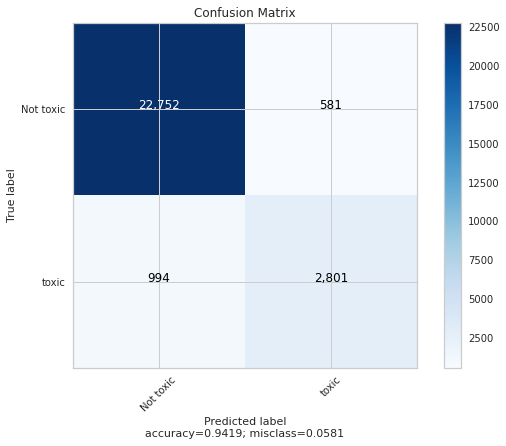

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     26384
         1.0       0.74      0.76      0.75       744

    accuracy                           0.99     27128
   macro avg       0.86      0.88      0.87     27128
weighted avg       0.99      0.99      0.99     27128


Confusion matrix
 [[26180   204]
 [  178   566]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     26384
         1.0       0.74      0.76      0.75       744

    accuracy                           0.99     27128
   macro avg       0.86      0.88      0.87     27128
weighted avg       0.99      0.99      0.99     27128

Accuracy: 0.985919
Precision: 0.735065
Recall: 0.760753
F1 score: 0.747688


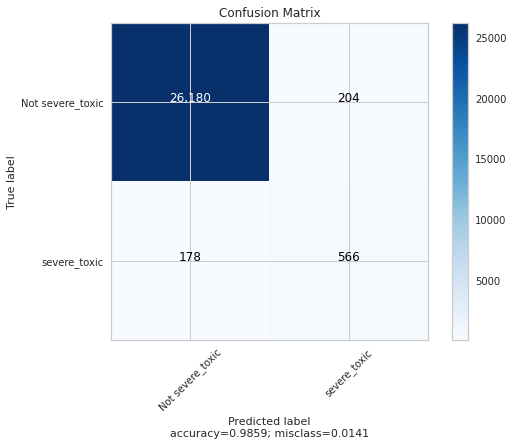

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25024
         1.0       0.85      0.85      0.85      2104

    accuracy                           0.98     27128
   macro avg       0.92      0.92      0.92     27128
weighted avg       0.98      0.98      0.98     27128


Confusion matrix
 [[24704   320]
 [  312  1792]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25024
         1.0       0.85      0.85      0.85      2104

    accuracy                           0.98     27128
   macro avg       0.92      0.92      0.92     27128
weighted avg       0.98      0.98      0.98     27128

Accuracy: 0.976703
Precision: 0.848485
Recall: 0.851711
F1 score: 0.850095


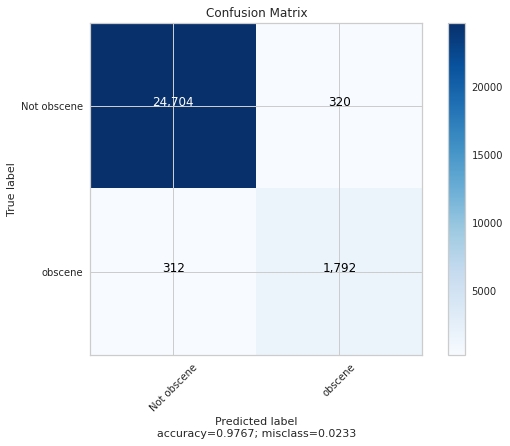

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26611
         1.0       0.96      0.88      0.92       517

    accuracy                           1.00     27128
   macro avg       0.98      0.94      0.96     27128
weighted avg       1.00      1.00      1.00     27128


Confusion matrix
 [[26594    17]
 [   63   454]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26611
         1.0       0.96      0.88      0.92       517

    accuracy                           1.00     27128
   macro avg       0.98      0.94      0.96     27128
weighted avg       1.00      1.00      1.00     27128

Accuracy: 0.997051
Precision: 0.963907
Recall: 0.878143
F1 score: 0.919028


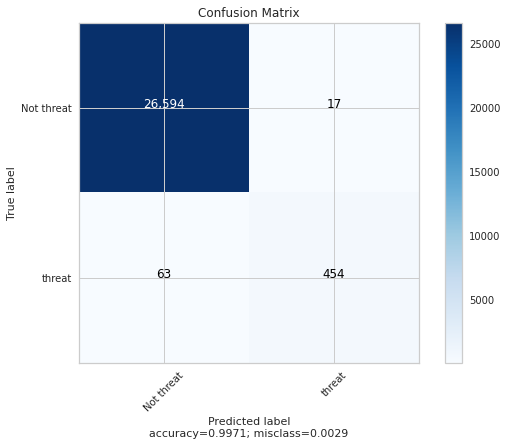

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     25092
         1.0       0.78      0.77      0.78      2036

    accuracy                           0.97     27128
   macro avg       0.88      0.88      0.88     27128
weighted avg       0.97      0.97      0.97     27128


Confusion matrix
 [[24649   443]
 [  459  1577]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     25092
         1.0       0.78      0.77      0.78      2036

    accuracy                           0.97     27128
   macro avg       0.88      0.88      0.88     27128
weighted avg       0.97      0.97      0.97     27128

Accuracy: 0.966750
Precision: 0.780693
Recall: 0.774558
F1 score: 0.777613


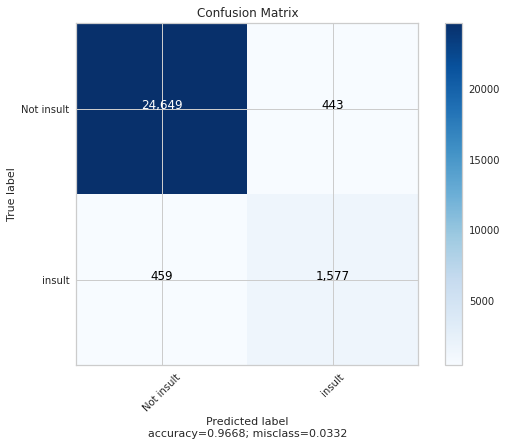

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26385
         1.0       0.84      0.78      0.81       743

    accuracy                           0.99     27128
   macro avg       0.92      0.89      0.90     27128
weighted avg       0.99      0.99      0.99     27128


Confusion matrix
 [[26274   111]
 [  160   583]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26385
         1.0       0.84      0.78      0.81       743

    accuracy                           0.99     27128
   macro avg       0.92      0.89      0.90     27128
weighted avg       0.99      0.99      0.99     27128

Accuracy: 0.990010
Precision: 0.840058
Recall: 0.784657
F1 score: 0.811413


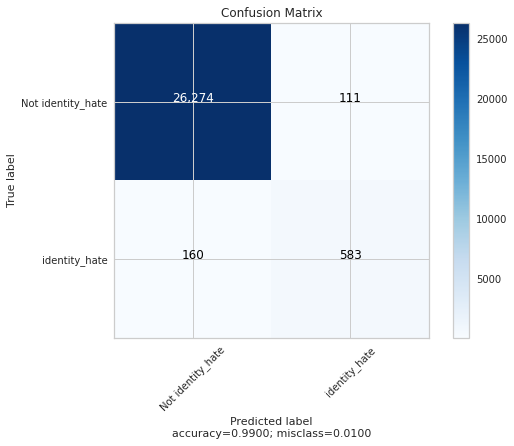

[[0.94194191 0.82820816 0.73807642 0.78054898]
 [0.98591861 0.73506494 0.76075269 0.74768824]
 [0.97670304 0.84848485 0.85171103 0.85009488]
 [0.99705102 0.96390658 0.87814313 0.91902834]
 [0.96675022 0.78069307 0.77455796 0.77761341]
 [0.99001032 0.84005764 0.7846568  0.81141267]]


In [13]:

y_val_predicted = model.predict(x_val_padded)  # predict_proba
result=np.ndarray(shape=(6,4))
for i,col in enumerate(target_col):
    
    y_val_predicted[:,i]= [ 1 if i>= 0.5 else 0 for i in y_val_predicted[:,i]]

    print(classification_report(y_val_predicted[:,i], y_val[:,i]))

    print('\nConfusion matrix\n',confusion_matrix(y_val_predicted[:,i], y_val[:,i]))
    print(classification_report(y_val_predicted[:,i], y_val[:,i]))

    accuracy = accuracy_score(y_val_predicted[:,i], y_val[:,i])
    print('Accuracy: %f' % accuracy)

    precision = precision_score(y_val_predicted[:,i], y_val[:,i])
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_val_predicted[:,i], y_val[:,i])
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val_predicted[:,i], y_val[:,i])
    print('F1 score: %f' % f1)
#     try:
#         print('ROC-AUC Score:',roc_auc_score(y_val_predicted[:,i], y_val[:,i]))
    
#     except:
#         continue
    result[i][0]=accuracy
    result[i][1]=precision
    result[i][2]=recall
    result[i][3]=f1  
    

    plot_confusion_matrix(cm       = confusion_matrix(y_val_predicted[:,i], y_val[:,i]), 
                      normalize    = False,
                      target_names = ['Not {}'.format(col) , '{}'.format(col)],
                      title        = "Confusion Matrix")
print(result)

In [ ]:
embeddings_index = dict()
f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_tokens, 100))

for word, i in tok.word_index.items():
    if i >= max_tokens: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model2 = Sequential()
model2.add(Embedding(max_tokens, 100, input_length=maxlen, weights=[embedding_matrix],trainable=False ))
model2.add(LSTM(256))
model2.add(Dense(32,activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(6, activation='sigmoid'))
model2.summary()

In [ ]:
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
    ModelCheckpoint(filepath='xceptionnet_{epoch:02d}_{val_accuracy:.04f}.h5',
                    save_best_only=False),
]

In [ ]:
y_train= np.array(y_train)
y_val= np.array(y_val)
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model2.fit(x_train_padded, y_train,batch_size=256,callbacks=my_callbacks, epochs=10,validation_data=(x_val_padded, y_val))
model2.save('/output/LSTM_Glove_19082021.h5')

In [12]:
y_train.shape

(113159, 6)

In [ ]:

y_val_predicted = model2.predict(x_val_padded)  # predict_proba
result=np.ndarray(shape=(6,4))
for i,col in enumerate(target_col):
    
    y_val_predicted[:,i]= [ 1 if i>= 0.5 else 0 for i in y_val_predicted[:,i]]

    print(classification_report(y_val_predicted[:,i], y_val[:,i]))

    print('\nConfusion matrix\n',confusion_matrix(y_val_predicted[:,i], y_val[:,i]))
    print(classification_report(y_val_predicted[:,i], y_val[:,i]))

    accuracy = accuracy_score(y_val_predicted[:,i], y_val[:,i])
    print('Accuracy: %f' % accuracy)

    precision = precision_score(y_val_predicted[:,i], y_val[:,i])
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_val_predicted[:,i], y_val[:,i])
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val_predicted[:,i], y_val[:,i])
    print('F1 score: %f' % f1)
    
    result[i][0]=accuracy
    result[i][1]=precision
    result[i][2]=recall
    result[i][3]=f1  
    
    plot_confusion_matrix(cm       = confusion_matrix(y_val_predicted[:,i], y_val[:,i]), 
                      normalize    = False,
                      target_names = ['Not {}'.format(col) , '{}'.format(col)],
                      title        = "Confusion Matrix")
print(result)